# 04 - K-Means clustering
This notebook performs K-Means clustering on the governance data set. It assumes the data was cleaned and placed in the cache by the "Explore the Governance Data Set" notebook.

This notebook is based on the steps from this article on medium. https://medium.com/@rohithramesh1991/unsupervised-text-clustering-using-natural-language-processing-nlp-1a8bc18b048d


---
## Dependencies and Imports

Here we import the libraries we need to perform our analysis.

In [1]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

import seaborn as sns
print(f"seaborn=={sns.__version__}")

from wordcloud import WordCloud
from wordcloud import __version__ as wordcloud__version__
print(f"wordcloud=={wordcloud__version__}")


python==3.11.4
scikit-learn==1.2.2
pandas==2.0.2
matplotlib==3.7.1
seaborn==0.12.2
wordcloud==1.9.2


---
## Apply K-Means to the Governance Data Set
We applied LSA to the subset _duurzaamheidsvisie_ (DV) documents from the governance data set. Next step is applying K-Means clustering.

### Load the DV Documents from the Governance Data

In [2]:
CACHE_DIR = '../cache/Governance'

GLOB_DV = CACHE_DIR + '/GM????DV??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"'Duurzaamheidsvisie' documents = {GLOB_DV}")

DOCUMENT_BODY = 'body'

def load_corpus_as_dataframe(glob):
    df = pd.DataFrame(data   =[file.read_text() for file in expand_glob(glob)],
                      index  =[file.stem        for file in expand_glob(glob)],
                      columns=[DOCUMENT_BODY])
    df[DOCUMENT_BODY] = df[DOCUMENT_BODY].astype(STRING)

    return df


'Duurzaamheidsvisie' documents = ../cache/Governance/GM????DV??.txt


In [3]:
def perform_lsa(dt_matrix, dictionary, n_components, column_names=None):
    svd = TruncatedSVD(n_components=n_components)
    explained_variance_sum = svd.fit(dt_matrix).explained_variance_.sum()
    lsa = svd.transform(dt_matrix)
    if not column_names:
        column_names = [f"topic {n}" for n in range(lsa.shape[1])]

    return pd.DataFrame(index=dt_matrix.index, data=lsa, columns=column_names), \
           pd.DataFrame(index=column_names, data=svd.components_, columns=dictionary).T, \
           explained_variance_sum           


In [4]:
# the caller is expected to select the right column from their data frame and
# pass it in as a series.
def compose_document_term_matrix(series, min_df, max_df, sublinear_tf):
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, sublinear_tf=sublinear_tf)
    dt_matrix  = vectorizer.fit_transform(series)
    dictionary = vectorizer.get_feature_names_out()

    return pd.DataFrame(index=series.index, columns=dictionary, data=dt_matrix.toarray()), \
           dictionary


In [5]:
corpus = load_corpus_as_dataframe(GLOB_DV)
corpus


,body
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...
GM0034DV01,verseonnr dagmail december raad gemeente almer...
...,...
GM1945DV01,duurzaamheidsprogramma gemeente groesbeek duur...
GM1955DV01,milieuprogramma gemeente Montferland vaststell...
GM1955DV02,notitie ruimtelijk inpassing stroomopwekking z...
GM1955DV03,energietransitienota duurzaam energie achterho...


In [6]:
document_term_matrix, dictionary = compose_document_term_matrix(corpus[DOCUMENT_BODY], min_df=15, max_df=0.85, sublinear_tf=True)
document_term_matrix

,aanbested,aanbesteding,aanbestedingen,aanbestedingsbeleid,aanbestedingstraject,aanbeveling,aanbieden,aanbieder,aanbieding,aanbod,...,zuidoost,zuinig,zuiniger,zuiveren,zuivering,zwaar,zwart,zwembad,zwerfafval,zwerfvuil
GM0003DV02,0.00000,0.011961,0.000000,0.000000,0.000000,0.038088,0.029612,0.0,0.0,0.012241,...,0.0,0.032091,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GM0005DV01,0.00000,0.014458,0.000000,0.000000,0.000000,0.000000,0.012821,0.0,0.0,0.000000,...,0.0,0.025169,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.091655,0.000000
GM0007DV01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017467,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.015561,0.000000,0.000000,0.037044,0.049653
GM0009DV01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018100,0.0,0.0,0.035368,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.033804,0.000000,0.000000
GM0034DV01,0.00000,0.015308,0.028343,0.000000,0.000000,0.000000,0.013575,0.0,0.0,0.000000,...,0.0,0.015739,0.0,0.000000,0.031880,0.034670,0.036210,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1945DV01,0.00000,0.022688,0.017603,0.026454,0.045707,0.000000,0.014275,0.0,0.0,0.000000,...,0.0,0.016551,0.0,0.033125,0.000000,0.021533,0.000000,0.000000,0.000000,0.000000
GM1955DV01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022652,0.0,0.0,0.015440,...,0.0,0.000000,0.0,0.000000,0.000000,0.048157,0.000000,0.000000,0.000000,0.000000
GM1955DV02,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.026038,...,0.0,0.026160,0.0,0.000000,0.000000,0.000000,0.060182,0.000000,0.000000,0.000000
GM1955DV03,0.00000,0.000000,0.000000,0.000000,0.000000,0.084665,0.013597,0.0,0.0,0.015692,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### LSA toepassen

In [7]:
topic_encodings, encoding_matrix, _ = perform_lsa(document_term_matrix, dictionary, 4, ["samenleving", "milieu", "mens en natuur", "energie"])


### Training the model

Bronnen: 
https://medium.com/@rohithramesh1991/unsupervised-text-clustering-using-natural-language-processing-nlp-1a8bc18b048d
https://campus.datacamp.com/courses/cluster-analysis-in-python/k-means-clustering-3?ex=1

In [8]:
Sum_of_squared_distances = []
K = range(1,100)
for k in K:
    km = KMeans(n_clusters=k, n_init=10)
    km = km.fit(topic_encodings)
    Sum_of_squared_distances.append(km.inertia_)

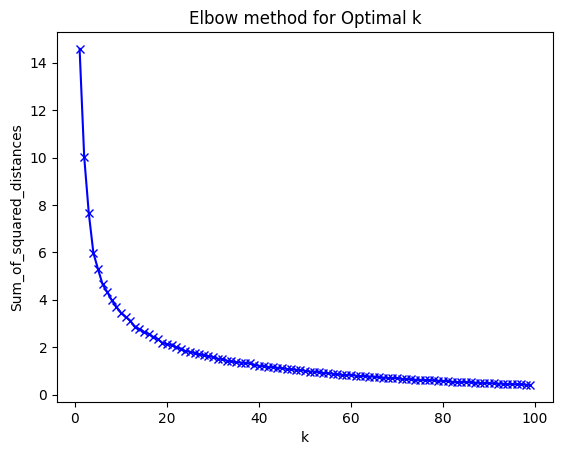

In [9]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow method for Optimal k')
plt.show()

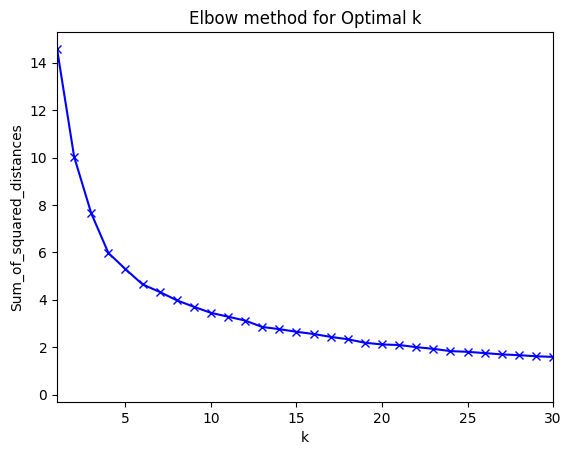

In [10]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow method for Optimal k')
plt.xlim(1, 30)
#plt.ylim(150, 170)
plt.show()

### Making sense of the clusters

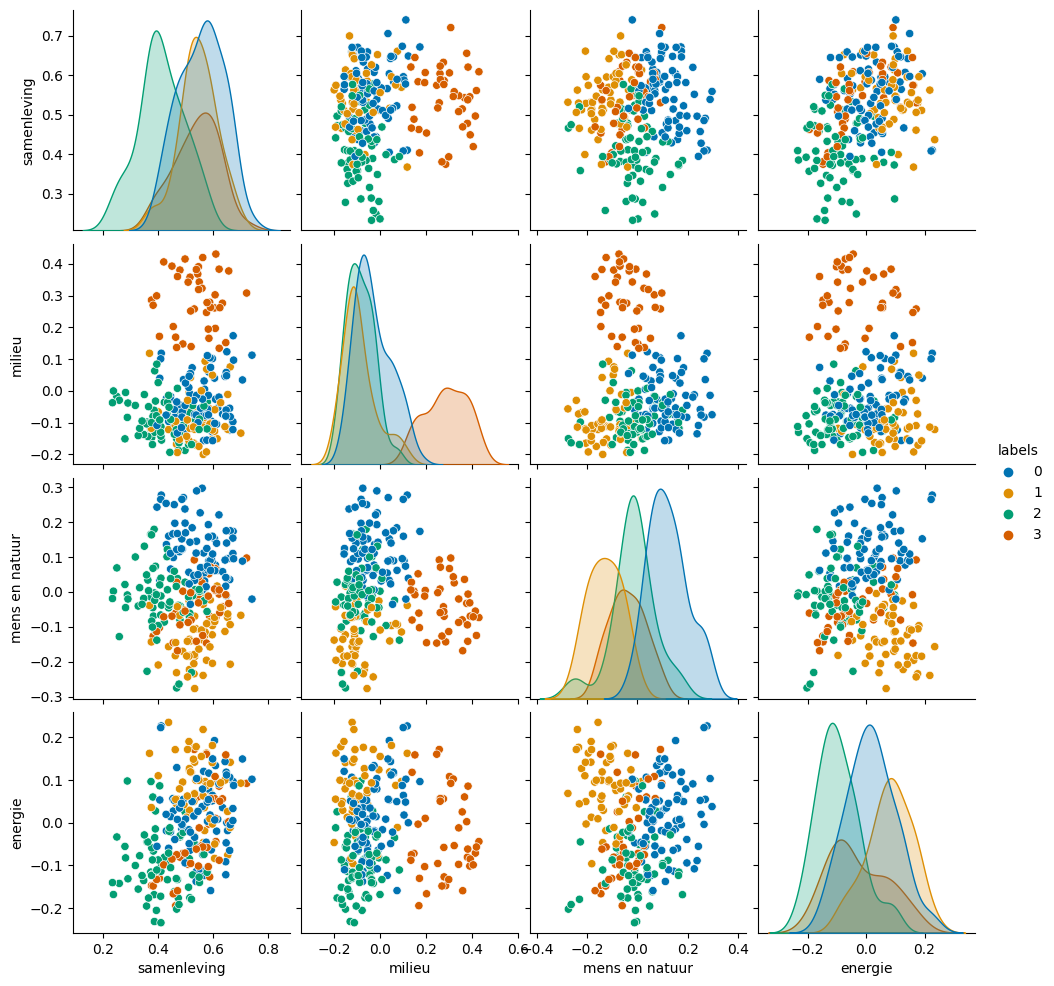

In [11]:
# K-means clustering met k=4
kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(topic_encodings)

topics = topic_encodings
topics['labels'] = kmeans.labels_
topics.to_parquet("../data/Governance/Kmeans_clusters.parquet")

# Scatterplots maken van de clusters per topic
fig = sns.pairplot(topics, hue='labels', palette="colorblind")


###  Silhouette score 
The silhouette score is a metric provided by scikit-learn that measures the quality of clustering results based on the average distance between samples within clusters and the average distance between samples in different clusters. It takes into account both the cohesion (how close samples are to each other within the same cluster) and the separation (how far samples are from samples in other clusters). The range is from -1 to 1.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [20]:
topic_encodings

,samenleving,milieu,mens en natuur,energie,labels
GM0003DV02,0.566258,-0.088296,-0.004682,0.035005,1
GM0005DV01,0.514658,0.357809,-0.079898,0.025207,3
GM0007DV01,0.542931,0.367695,0.035778,0.060209,3
GM0009DV01,0.454025,-0.103783,0.098209,0.027366,0
GM0034DV01,0.484799,-0.053676,0.151439,-0.014625,0
...,...,...,...,...,...
GM1945DV01,0.626101,-0.037390,-0.044870,0.093202,1
GM1955DV01,0.469120,0.359887,-0.168246,-0.159358,3
GM1955DV02,0.404564,-0.091647,0.019988,0.086200,2
GM1955DV03,0.504876,-0.091648,-0.141210,0.062371,1


In [12]:
silhouette_avg = silhouette_score(topic_encodings, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.8035771179655398


The score is close to 0 this indicates that the clusters are overlapping or ambiguous.

---
## Word Clouds (Again)

In [13]:
encoding_matrix

,samenleving,milieu,mens en natuur,energie
aanbested,0.014110,-0.009761,-0.005041,-0.029616
aanbesteding,0.024423,0.000810,-0.004206,-0.020407
aanbestedingen,0.009246,-0.001432,0.008753,-0.004396
aanbestedingsbeleid,0.011459,-0.006624,0.004586,-0.010978
aanbestedingstraject,0.005343,0.001847,-0.006656,-0.012793
...,...,...,...,...
zwaar,0.015062,0.016462,0.005776,0.014304
zwart,0.005122,-0.005599,0.009590,0.004129
zwembad,0.012588,-0.009673,-0.007463,-0.022542
zwerfafval,0.020227,0.045377,0.014911,-0.031068


In [14]:
def wordcloud_of_topic(series):
    print(series.sort_values(ascending=False)[:20])
    cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(series.sort_values(ascending=False))
    plt.axis('off')
    plt.imshow(cloud);


eur                0.049944
afval              0.049168
maatschappelijk    0.046794
water              0.046491
wij                0.045539
programma          0.045537
natuur             0.045243
mobiliteit         0.044971
ruimtelijk         0.044866
communicatie       0.044820
extern             0.043928
regio              0.043753
ondernemer         0.043601
actie              0.043277
vaststellen        0.043270
concreet           0.043086
overheid           0.043063
verlichting        0.042938
huidig             0.042903
economisch         0.042903
Name: samenleving, dtype: float64


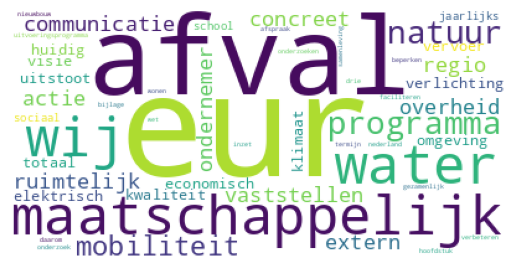

In [15]:
wordcloud_of_topic(encoding_matrix['samenleving'])


gevaarlijk             0.101739
geluid                 0.091736
melding                0.088081
milieutak              0.085916
veiligheid             0.084857
omgevingsvergunning    0.080936
bodemkwaliteit         0.080083
wabo                   0.079267
milieubeleidsplan      0.078224
milieubeleid           0.076560
vergunningverlening    0.075336
milieuprogramma        0.073661
sanering               0.072818
klacht                 0.072412
besluit                0.070501
luchtkwaliteit         0.069604
toezicht               0.068312
handhaving             0.066481
stof                   0.066440
bodembeheer            0.065839
Name: milieu, dtype: float64


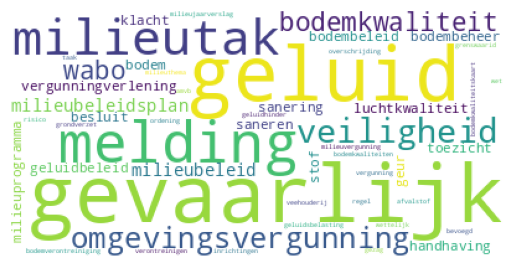

In [16]:
wordcloud_of_topic(encoding_matrix['milieu'])


ecologisch            0.081777
stad                  0.072211
cradle                0.065345
verbinding            0.065197
biodiversiteit        0.065055
sociaal               0.064944
leven                 0.062161
circulair             0.058274
duurzaamheidsvisie    0.058199
voedsel               0.056773
diversiteit           0.056068
planet                0.054362
people                0.054007
natuur                0.052380
toekomstbestendig     0.051399
plek                  0.050476
gezond                0.048594
identiteit            0.048177
generatie             0.048062
balans                0.047806
Name: mens en natuur, dtype: float64


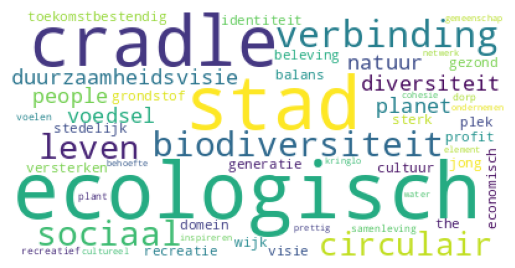

In [17]:
wordcloud_of_topic(encoding_matrix['mens en natuur'])


windturbine           0.077226
energievraag          0.069985
epc                   0.069683
emissie               0.055796
klimaatbeleid         0.055357
turbine               0.054951
senternovem           0.054928
biomassa              0.054417
kyoto                 0.053677
aardgas               0.051300
gemeentegrens         0.050989
broeikasgass          0.049971
figuur                0.049865
utiliteitsgebouw      0.049374
klimaatverandering    0.049182
energetica            0.048806
trias                 0.048251
bio                   0.047699
fors                  0.046893
brandstof             0.045885
Name: energie, dtype: float64


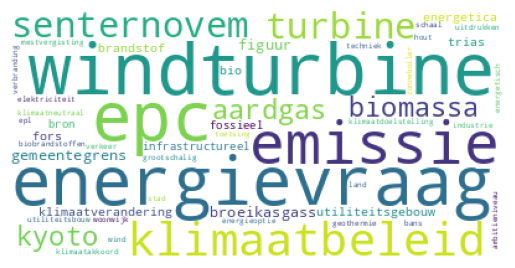

In [18]:
wordcloud_of_topic(encoding_matrix['energie'])


In [19]:

# topic_encodings.to_parquet("../data/Governance/LSA_document_topic_matrix.parquet")
